# All Models, All Features (Except Secondary Structure), One-hot Encoding

In [1]:
%load_ext watermark
%watermark -p pandas,numpy,scikit-learn,matplotlib --conda 

pandas      : 1.4.4
numpy       : 1.23.3
scikit-learn: 1.1.2
matplotlib  : 3.5.3

conda environment: hotspot



In [2]:
import pandas as pd
import numpy as np

## Binarize

In [3]:
df_train = pd.read_csv('../dataset/TrainingDataset.csv')
df_test = pd.read_csv('../dataset/TestDataset.csv')

# 1 & 2 -> 1
# 0 -> 0

binarized = df_train['3-class'].values.copy()
binarized[binarized == 2] = 1
df_train['2-class-merged-v1'] = binarized.astype(int)

binarized = df_test['3-class'].values.copy()
binarized[binarized == 2] = 1
df_test['2-class-merged-v1'] = binarized.astype(int)


y_train = df_train['2-class-merged-v1'].values
y_test = df_test['2-class-merged-v1'].values

## Use All Features (Except Secondary Structure)

In [4]:
np.unique(df_train['residue'])

array(['C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q',
       'R', 'S', 'T', 'V', 'W', 'Y'], dtype=object)

In [5]:
# convert aa char to int
codes = ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 
         'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
code_to_int = {c:i for i,c in enumerate(codes)}     
df_train['residue'] = df_train['residue'].map(code_to_int)
df_test['residue'] = df_test['residue'].map(code_to_int)

In [6]:
feature_list = ['avg bond number', 'Hbond', 'residue',
                'Hphob', 'consurf', "B' side chain", 'asa']

df_train = df_train[feature_list]
df_test = df_test[feature_list]

In [7]:
df_train['residue'] = df_train['residue'].astype('category')
df_test['residue'] = df_test['residue'].astype('category')


In [8]:
df_train.dtypes

avg bond number     float64
Hbond                 int64
residue            category
Hphob                 int64
consurf               int64
B' side chain       float64
asa                 float64
dtype: object

In [9]:
X_train = df_train[feature_list].values
X_test =  df_test[feature_list].values

In [10]:
X_train.shape

(732, 7)

In [11]:
y_train.shape

(732,)

In [12]:
X_test.shape

(314, 7)

In [13]:
y_test.shape

(314,)

In [14]:
X_train[:, [2, 6]]

array([[13.   ,  2.089],
       [ 1.   ,  0.637],
       [14.   ,  0.226],
       ...,
       [19.   ,  0.872],
       [14.   ,  0.147],
       [ 1.   ,  0.   ]])

## OneHot Encoding

In [15]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(drop='first')
ohe.fit(df_train[feature_list][['residue']])

OneHotEncoder(drop='first')

In [16]:
df_train_ohe = df_train.drop(columns=['residue'])
df_test_ohe = df_test.drop(columns=['residue'])

In [17]:
ohe_train = np.asarray(ohe.transform(df_train[feature_list][['residue']]).todense())
ohe_test = np.asarray(ohe.transform(df_test[feature_list][['residue']]).todense())

In [18]:
X_train_ohe = np.hstack((df_train_ohe.values, ohe_train))
X_test_ohe = np.hstack((df_test_ohe.values, ohe_test))

## Confusion Matrices

In [19]:
from joblib import load


pipe = load('../../hotspotter/mlp_sequence_only.joblib')

In [20]:
pred_train = pipe.predict(X_train_ohe)
pred_test = pipe.predict(X_test_ohe)

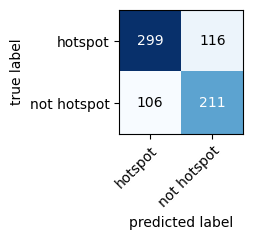

In [21]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


cm_train = confusion_matrix(y_target=y_train, 
                            y_predicted=pred_train)

class_dict = {0: 'hotspot',
              1: 'not hotspot'}

fig, ax = plot_confusion_matrix(cm_train, figsize=(3.5, 2.5), class_names=class_dict.values())

plt.tight_layout()
plt.savefig('mlp_train_sequence-only.pdf')
plt.show()

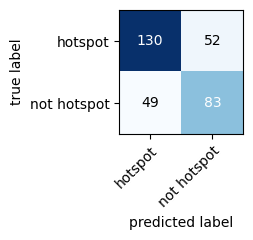

In [22]:
cm_test = confusion_matrix(y_target=y_test, 
                            y_predicted=pred_test)

class_dict = {0: 'hotspot',
              1: 'not hotspot'}

fig, ax = plot_confusion_matrix(cm_test, figsize=(3.5, 2.5), class_names=class_dict.values())

plt.tight_layout()
plt.savefig('mlp_test_sequence-only.pdf')
plt.show()